In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from lxml import html
import requests
import json 
from bs4 import BeautifulSoup
from scipy import stats
from statistics import mean 
import plotly.express as px
import tmdbsimple as tmdb
import pycountry

# Introduction  & Research Question 

The advancement of technology has enabled the number of films produced worldwide to sky-rocket. Along with that, the spread of Internet accessibility and the development of Over-The-Top (OTT) on demand streaming services (i.e Netflix) have assisted the establishment of movie-watching as one of the most preferred leisure activities of individuals all over the world (“Netflix and chill”).

A lot of platforms exist, that aggregate information about films (IMDB  and TMDB), where users can log, comment on and rate their favorite (or least favorite) movies. 

The objective of this analysis is to attempt to shine light on the association of a movie’s general characteristics and its received rating.

# Data Description

The bulk of the information is drawn by an existing dataset from Kaggle [https://www.kaggle.com/rounakbanik/the-movies-dataset]. The associated file is a csv file, “movies_metadata.csv”, which is derived from a movie platform called TMDB (https://www.themoviedb.org/). The dataset was created on 2017 and contains the features mentioned below:

*	Budget
*	Genre
*	id (ID in TMDb)
*	Imdb_id (ID in IMDb)
*	Original_language
*	popularity 
*	production_countries
*	release_date
*	revenue
*	runtime
*	spoken_languages
*	title
*	vote_average (the average vote existing in the TMDB website for the year 2017)
*	vote_count (number of votes existing in the TMDB website for the year 2017)

The said dataset is extended by adding 4 extra features. The ratingCount and ratingValue of each movie provided by the IMDB website and the vote_count and vote_average provided by the TMDB website (all those features where derived at 3/1/2020). Web scraping was used for parsing data from IMDB website and the TMDB API was used for parsing data from TMDB database.

Lastly, the vote average cannot always be considered as an accurate score for a movie. For instance, if a movie is rated only by one person we cannot conclude whether this movie is good or bad. For this reason, the IMDB score formula is used in order to calculate the score per movie.
This formula provides a true 'Bayesian estimate', which takes into account the number of votes each movie has received, minimum votes required to be on the list, and the mean vote for all titles:


weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

Where:

R = average for the movie (mean) (Rating)

v = number of votes for the movie (votes)

m = the minimum number of votes required for the movie to be in the chart (the prerequisite) 

C = the mean vote across the whole report


For al the rating provided in our dataset, the score per movie is calculated using the above formula.
Finally we have the below extra columns:

*    score: the score per movie using ratings from TMDB found at year 2017
*    score_20: the score per movie using data from IMDB found at year 2020
*    score_imdb: the score per movie using data from IMDB found at year 2020 


# Data Acquisition 

### IMDB Web scraping

In [38]:
#import dataset
dataset=pd.read_csv("./dataset/movies_metadata.csv")

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



In [39]:
# keep only columns needed for our analysis 
dataset=dataset[['budget','genres','id','imdb_id','original_language','production_companies','production_countries','release_date','revenue','runtime','spoken_languages','title','vote_average','vote_count']]

In [40]:
# check the are any outliers in genres column
genres_=dataset.groupby('genres').size().reset_index(name='counts')
genres_.sort_values('counts', ascending=False).head(5)

,genres,counts
2005,"[{'id': 18, 'name': 'Drama'}]",5000
3203,"[{'id': 35, 'name': 'Comedy'}]",3621
4065,"[{'id': 99, 'name': 'Documentary'}]",2723
0,[],2442
1517,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",1301


### Web Scraping for data collection from IMDB website 

After examining the initial dataset empty values are found in genres field. In order to fill empty values, those data are parsed again via webscraping technique from IMDB website. Also, the number of ratings (ratingCount_imdb) and the average rating (ratingValue_imdb) per movie are parsed.

The web scraping technique is quite time consuming ( + my internet connection is not the best one). In order to parse the data more quickly the initial dataset movies_metadata.csv is splitted into 13 chunks. In this way, I parallelized the process.

Below can be found the implemented process for parsing those data.

In [ ]:
dataset["ratingCount_imdb"] = np.nan
dataset["ratingValue_imdb"] = np.nan
dataset["gernres_imdb"] = np.nan

ds_test=dataset

url = 'https://www.imdb.com/title/'
resp = requests.get(url)

problem_=[]
c1_=c2_=0
cn=0
for index,i in ds_test.iterrows():
    cn=cn+1
    print (index)
    # create url per movie 
    url_= url+str(i['imdb_id'])+'/'
    # request data from this url 
    resp = requests.get(url_)
    # when response code is 200 then the process is successfully completed
    if (resp.status_code == 200):
        soup = BeautifulSoup(resp.text,  from_encoding='utf-8')
        # parse from the response specific data 
        # data have json format
        l=soup.find_all('script', type="application/ld+json")
        if (len(l)<1): # if data do not exists 
            print ("soup problem")
            c1_=c1_+1
        else: # if data exists parse genres, ratingCount , ratingValue fields
            for j in l : 
                 res=j.get_text()
            ds_test.loc[index,'parsed_data']=str(res)
            d=json.loads(str(res))

            # AggregateRating       
            if 'aggregateRating' in d:
                if 'ratingCount' in d['aggregateRating']:
                    rating_Count=d['aggregateRating']['ratingCount']
                    ds_test.loc[index,'ratingCount']=rating_Count
                if 'ratingValue' in d['aggregateRating']:
                    rating_Value=d['aggregateRating']['ratingValue']
                    ds_test.loc[index,'ratingValue']=rating_Value

            # Genre
            if 'genre' in d:
                ds_test.loc[index,'gernres_imdb']=str(d['genre'])
                    
    else : 
        c2_=c2_+1
        problem_.append(i)

The main reason that the dataset was extended with information derived from the IMDB website is that there are, roughly, more votes per movie in IMDb than there are in TMDb. So the ratings may be more indicative in terms of the public opinion formulated for every film. In addition, IMDB is considered to be more popular that TMDB so the data provided are considered to be more legitimate. This can be found  in the section below , Descriptive Statistics.

### MOVIE DB API

In order to retrieve the current vote_average and vote_count per movie the TMDB API is used. 

The below procedure is parallelized by deviding the dataset into 4 chunks.

Below can be found the implemented process for parsing those data.

In [ ]:
tmdb.API_KEY= 'a03899b97f5adf7c2de7c820c3c3f23c'
l=dataset
l["vote_count_2020"] = np.nan
l["vote_average_2020"] = np.nan

cb=0
for index,i in l.iterrows():
    tmdb.API_KEY= 'a03899b97f5adf7c2de7c820c3c3f23c'
    tmdb.language = 'en'
    movie = tmdb.Movies(i['id'])
    try:
        response = movie.info()
        l.loc[index,'vote_count_2020']=movie.vote_count
        l.loc[index,'vote_average_2020']=movie.vote_average
    except :
        print ('Problem')


Finally, data after web scraping and API's process data is saved in './dataset/final_extended_movies.csv' file 


### Data Cleansing and shaping 

In [57]:
# import extended dataset
movies_dataset=pd.read_csv('./dataset/final_extended_movies.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning:

Columns (4,6,9,14,25) have mixed types. Specify dtype option on import or set low_memory=False.



In [58]:
movies_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 36 columns):
Unnamed: 0               45466 non-null int64
Unnamed: 0.1             45466 non-null int64
Unnamed: 0.1.1           45466 non-null int64
Unnamed: 0.1.1.1         45466 non-null int64
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
reve

In [59]:
# drop first 4 columns 
movies_dataset.drop(movies_dataset.iloc[:, :4], inplace = True, axis = 1) 
# generate release year column 
movies_dataset['release_year']=movies_dataset['release_date'].apply(lambda row: str(row)[:4])
movies_dataset=movies_dataset[movies_dataset.release_year.apply(lambda x: x.isnumeric())]
# keep only movies (not TV-Series)
movies_dataset=movies_dataset[movies_dataset['runtime']<float(240)]
# keep only movies that their initial language is English 
movies_dataset=movies_dataset[movies_dataset['original_language']=='en']

###  Calculate Score per movie

In [60]:
df=movies_dataset

In [61]:
# vote_average 
C_17= df['vote_average'].mean()
# minimum votes required 
m_17= df['vote_count'].quantile(0.80)

C_20= df['vote_average_2020'].mean()
m_20= df['vote_count_2020'].quantile(0.80)

C_imdb= df['ratingValue_imdb'].mean()
m_imdb= df['ratingCount_imdb'].quantile(0.80)

# keep only movies that have specific number of votes 
q_movies_2017 = df.copy().loc[df['vote_count'] >= m_17]
q_movies_2020 = df.copy().loc[df['vote_count_2020'] >= m_20]
q_movies_imdb = df.copy().loc[df['ratingCount_imdb'] >= m_imdb]

In [62]:
# IMDB formula
def weighted_rating_2017(x, m=m_17, C=C_17):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

def weighted_rating_2020(x, m=m_20, C=C_20):
    v = x['vote_count_2020']
    R = x['vote_average_2020']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

def weighted_rating_imdb(x, m=m_imdb, C=C_imdb):
    v = x['ratingCount_imdb']
    R = x['ratingValue_imdb']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [63]:
q_movies_2017['score_17'] = q_movies_2017.apply(weighted_rating_2017, axis=1)
q_movies_2017=q_movies_2017.sort_values('score_17', ascending=False)
# q_movies_2017[['title','score_17','vote_count','vote_average']].head(10)

In [64]:
q_movies_2020['score_20'] = q_movies_2020.apply(weighted_rating_2020, axis=1)
q_movies_2020=q_movies_2020.sort_values('score_20', ascending=False)
#q_movies_2020[['title','score_20','vote_count_2020','vote_average_2020']].head(10)

In [65]:
q_movies_imdb['score_imdb'] = q_movies_imdb.apply(weighted_rating_imdb, axis=1)
q_movies_imdb=q_movies_imdb.sort_values('score_imdb', ascending=False)
#q_movies_imdb[['title','score_imdb','ratingCount_imdb','ratingValue_imdb','runtime']].head(10)

In [66]:
# inner join the three datasets in order to keep only common movies that will be used for our analysis 
merged_inner1 = pd.merge(left=q_movies_2017,right=q_movies_2020, left_on='id', right_on='id')
merged_inner1=merged_inner1[['adult_x','belongs_to_collection_x','budget_x','genres_x','id','imdb_id_x','original_language_x','original_title_x','popularity_x','production_companies_x','production_countries_x','release_date_x','revenue_x','runtime_x','spoken_languages_x','title_x','vote_average_x','vote_count_x','director_imdb_x','actor_imdb_x','ratingCount_imdb_x','ratingValue_imdb_x','gernres_imdb_x','vote_count_2020_x','vote_average_2020_x','release_year_x','score_20','score_17']]
merged_inner2 = pd.merge(left=merged_inner1,right=q_movies_imdb, left_on='id', right_on='id')
merged_inner2=merged_inner2[['adult_x','belongs_to_collection_x','budget_x','genres_x','id','imdb_id_x','original_language_x','original_title_x','popularity_x','production_companies_x','production_countries_x','release_date_x','revenue_x','runtime_x','spoken_languages_x','title_x','vote_average_x','vote_count_x','director_imdb_x','actor_imdb_x','ratingCount_imdb_x','ratingValue_imdb_x','gernres_imdb_x','vote_count_2020_x','vote_average_2020_x','release_year_x','score_20','score_17','score_imdb']]
merged_inner2.columns = ['adult','belongs_to_collection','budget','genres','id','imdb_id','original_language','original_title','popularity','production_companies','production_countries','release_date','revenue','runtime','spoken_languages','title','vote_average','vote_count','director_imdb','actor_imdb','ratingCount_imdb','ratingValue_imdb','gernres_imdb','vote_count_2020','vote_average_2020','release_year','score_20','score_17','score_imdb']

In [67]:
final=merged_inner2
final.shape
# So the number of movies used for our analysis are 5681

(5681, 29)

Generate release year column per movie and decade that the movie was released

In [68]:
# find release year per movie
final['release_year']=final['release_date'].apply(lambda row: str(row)[:4])
final=final[final.release_year.apply(lambda x: x.isnumeric())]
final['release_year']=final['release_year'].astype(int)
# convert budget to numeric value 
final["budget"] = pd.to_numeric(final["budget"])

In [69]:
# create column decade per movie 
for index,i in final.iterrows():
    i=i['release_year']
    if   i>=1870 and i<1880: final.loc[index,'decade']='1870-80'
    elif i>=1880 and i<1890: final.loc[index,'decade']='1880-90'
    elif i>=1890 and i<1900: final.loc[index,'decade']='1890-00'
    elif i>=1900 and i<1910: final.loc[index,'decade']='1900-10'      
    elif i>=1910 and i<1920: final.loc[index,'decade']='1910-20'
    elif i>=1920 and i<1930: final.loc[index,'decade']='1920-30'
    elif i>=1930 and i<1940: final.loc[index,'decade']='1930-40'
    elif i>=1940 and i<1950: final.loc[index,'decade']='1940-50'       
    elif i>=1950 and i<1960: final.loc[index,'decade']='1950-60'       
    elif i>=1960 and i<1970: final.loc[index,'decade']='1960-70'      
    elif i>=1970 and i<1980: final.loc[index,'decade']='1970-80'       
    elif i>=1980 and i<1990: final.loc[index,'decade']='1980-90'       
    elif i>=1990 and i<2000: final.loc[index,'decade']='1990-10'       
    elif i>=2000 and i<2010: final.loc[index,'decade']='2000-10'
    elif i>=2010 and i<2020: final.loc[index,'decade']='2010-18'    
        

In [70]:
 final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5681 entries, 0 to 5680
Data columns (total 30 columns):
adult                    5681 non-null object
belongs_to_collection    1369 non-null object
budget                   5681 non-null int64
genres                   5681 non-null object
id                       5681 non-null object
imdb_id                  5681 non-null object
original_language        5681 non-null object
original_title           5681 non-null object
popularity               5681 non-null object
production_companies     5681 non-null object
production_countries     5681 non-null object
release_date             5681 non-null object
revenue                  5681 non-null float64
runtime                  5681 non-null float64
spoken_languages         5681 non-null object
title                    5681 non-null object
vote_average             5681 non-null float64
vote_count               5681 non-null float64
director_imdb            5680 non-null object
actor_imdb      

In [23]:
# save data to file in order to use it for Part 2 
final.to_csv('./dataset/final.csv')

# Descriptive statistics

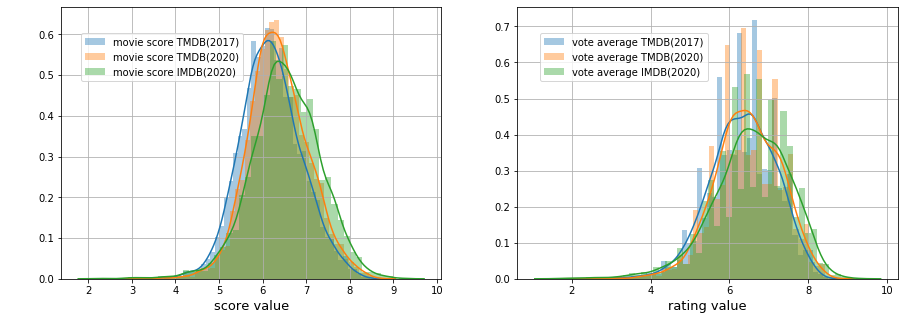

In [71]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust( wspace=0.2)
ax1 = fig.add_subplot(1, 2 ,1)
ax2 = fig.add_subplot(1, 2, 2)
# Figure 1
sns.distplot(final['score_17'], ax=ax1)
sns.distplot(final['score_20'], ax=ax1)
sns.distplot(final['score_imdb'], ax=ax1)
fig.legend(labels=['movie score TMDB(2017)','movie score TMDB(2020)','movie score IMDB(2020)'],loc='upper right', bbox_to_anchor=(0.23,0.81) )
ax1.set_xlabel('score value',  fontsize=13)     
ax1.grid(True)
# Figure 2
sns.distplot(final['vote_average'], ax=ax2)
sns.distplot(final['vote_average_2020'], ax=ax2)
sns.distplot(final['ratingValue_imdb'], ax=ax2)
ax2.set_xlabel('rating value',  fontsize=13)     
fig.legend(labels=['vote average TMDB(2017)','vote average TMDB(2020)','vote average IMDB(2020)'],loc='upper right', bbox_to_anchor=(0.66,0.81))
ax2.grid(True)


The first presented plot is a histogram of the score values of the movies. The scores are clustered into three separate subgroups. One for the movie score according to TMDb in 2017 (blue), one for the movie score according to TMDb in 2020 (orange) and one for the movie score according to IMDb in 2020 (green). We infer a distribution line for every one of the subgroups (different colors) presented in the histogram. We observe that each one of the separate distributions resembles the Gaussian. The mean of the score of IMDb movies (around 6.5) is a little higher than the TMDb score (around 6.2) for the same year (2020). The mean of the TMDb score for 2017 is the lowest among the three (around 6.1).

The same, pretty much, holds for the second histogram presented for the rating value. We can notice that the mean of the rating value for TMDb in 2020 is roughly the same as the same metric in 2017.

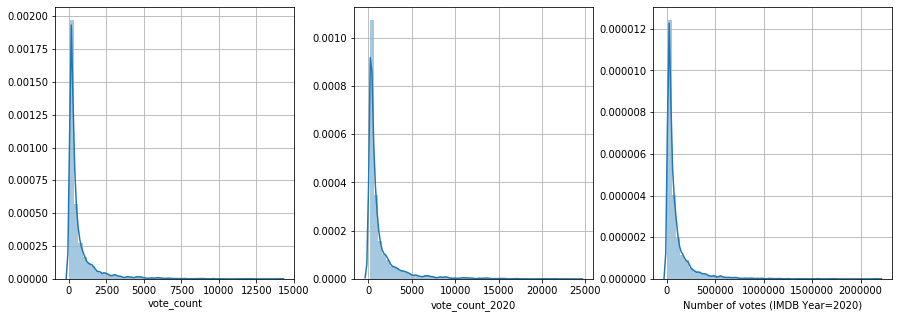

In [72]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust( wspace=0.25)
ax1 = fig.add_subplot(1, 3 ,1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
# Figure 1
sns.distplot(final['vote_count'], ax=ax1)
plt.xlabel('Number of votes (TMDB Year=2017)')
ax1.grid(True)
# Figure 2
sns.distplot(final['vote_count_2020'], ax=ax2)
plt.xlabel('Number of votes (TMDB Year=2020)')
ax2.grid(True)
# Figure 3
sns.distplot(final['ratingCount_imdb'], ax=ax3)
plt.xlabel('Number of votes (IMDB Year=2020)')
ax3.grid(True)


All graphs are left skewed which shows tha people do not vote that much. However, there are much more ratings in IMDB database than in TMDB database, so the results from IMDB are more indicative.

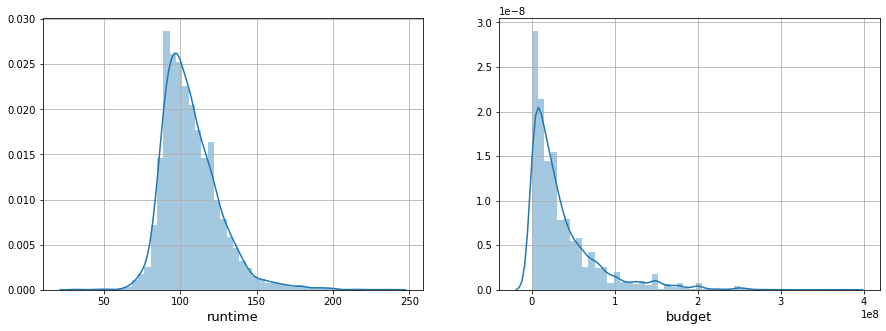

In [73]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust( wspace=0.2)
ax1 = fig.add_subplot(1, 2 ,1)
ax2 = fig.add_subplot(1, 2, 2)

# Figure 1
runtime_=final[final['runtime']>30]
sns.distplot(runtime_['runtime'], ax=ax1)
ax1.set_xlabel('runtime',  fontsize=13)     
ax1.grid(True)

# Figure 2
budget_=final[final['budget']>10000]
sns.distplot(budget_['budget'], ax=ax2)
ax2.set_xlabel('budget',  fontsize=13)     
ax2.grid(True)

In [75]:
final.groupby(['budget']).size()[:10]

budget
0      1397
1         4
5         1
6         1
8         2
28        1
30        1
93        1
108       1
113       1
dtype: int64

In [76]:
runtime=pd.DataFrame(final.groupby(['runtime']).size())
runtime.sort_values(by=[0], inplace=True, ascending=False)
runtime.head()

,0
runtime,
100.0,180
97.0,164
95.0,159
98.0,154
90.0,153


We present a histogram of the duration (runtime) of the movies presented in the dataset and infer a distribution line. We notice that the duration resembles the normal distribution and the mean duration is approximately 100 minutes. 

The same is done for the movies budget and we notice that the mean budget is less than a million dollars.
Also, in approximatelly 25% cases the budget is invalid close to 0 dollars.

In [35]:
import plotly#.plotly as py
plotly.offline.init_notebook_mode(connected=True)

movies_per_decade=final.groupby('decade').size().reset_index(name='counts')
fig = px.pie(movies_per_decade, values='counts', names='decade', title='Number of movies per decade')
fig.show()

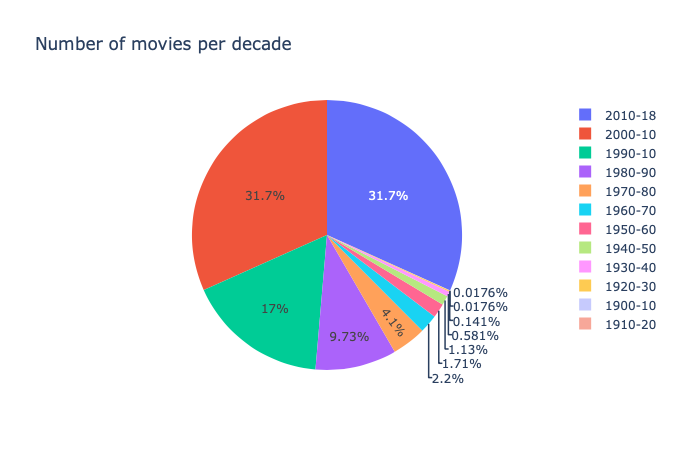

In [83]:
from IPython.display import Image
Image(filename='./Figures/pie_plot.png')

We demonstrate a pie chart constructed by the movies produced per decade (from 1900s to 2010s). We notice that the production of movies is increasing every decade. The number of movies is, approximately, being doubled every decade till the 2000s. The movies released in 2010s are, approximately, as many as they were in 2000s but the number shown for the 2010s is representing the activity from 2011 till 2018.

In [77]:
movies_per_year=final.groupby('release_year').size().reset_index(name='counts')
movies_per_year=movies_per_year[movies_per_year['release_year']>1930]

Text(0, 0.5, 'Number of movies')

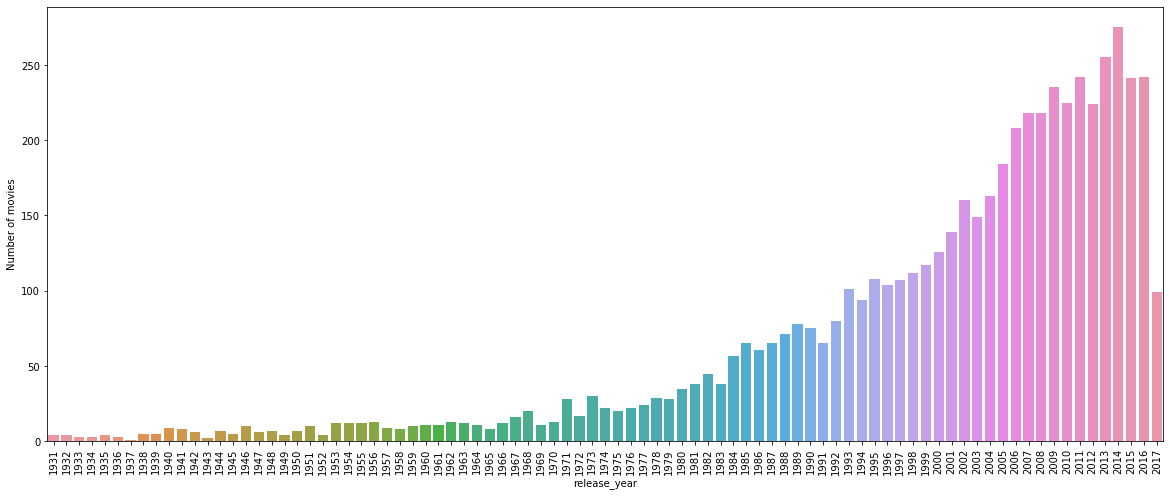

In [80]:
plt.figure(figsize=(20,8))

ax = sns.barplot(x="release_year", y="counts", data=movies_per_year)
plt.xticks(rotation='vertical')
plt.ylabel('Number of movies')

Through this barplot, we can conclude that the number of movies per year tend to increase. 

In [29]:
import json 

for index,i in final.iterrows():
    cn=final.loc[index,'production_countries']
#     print (index)
#     print (cn)
    if cn!='[]' and str(cn)!='nan': 
        k=cn[1:]
        k=k[:-1]
        k=k.replace("'", '"')
        d="}"
        s =  [e+"}" for e in k.split(d) if e]
        ls=[]
        for j in s:
            l=j.replace(", {", '{')
            l=l.replace('"}', "")
            l=l.split(", ")
            ls.append(l[1][9:])
    final.loc[index,'production_countries']=str(ls)




In [30]:
# dataframe with movies indexes per genre
prd_cn=pd.DataFrame(columns=['production_countries','indexes','score_17','score_20','score_imdb'])
prd_cn=prd_cn.set_index('production_countries')
exists=first_time=0
ls=[]

for index,i in final.iterrows():
    g=final.loc[index,'production_countries']
    if (g!=np.nan and g!="" and isinstance(g, str) ):
        k=g[2:]
        k=k[:-2]
        g=k.split(",")
        ls.append(g)
        for g_ in g:
            g_= g_.replace(" '", "")
            g_= g_.replace("'", "")
            if g_ in prd_cn.index.values : 
                exists=exists+1
                prd_cn.loc[g_,'indexes'].append(index)
                prd_cn.loc[g_,'score_17'].append(final.loc[index,'score_17'])
                prd_cn.loc[g_,'score_20'].append(final.loc[index,'score_20'])
                prd_cn.loc[g_,'score_imdb'].append(final.loc[index,'score_imdb'])
            else:
                first_time=first_time+1
                k=[index]
                prd_cn.loc[g_] = [k,[final.loc[index,'score_17']],[final.loc[index,'score_20']],[final.loc[index,'score_imdb']]]



,indexes,score_17,score_20,score_imdb
production_countries,,,,
United States of America,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[8.476091921724109, 8.466930625599343, 8.28475...","[8.674521688325227, 8.56794918161479, 8.383806...","[9.28432711895008, 9.178033163539174, 8.985736..."
United Kingdom,"[2, 17, 19, 25, 31, 36, 38, 40, 45, 47, 49, 54...","[8.284757979938846, 8.08765198985473, 8.084483...","[8.383806800573895, 8.28669640147885, 8.284320...","[8.98573699478687, 8.785018629235687, 8.580677..."
Germany,"[3, 31, 38, 53, 80, 95, 119, 141, 146, 259, 28...","[8.280705432583439, 8.012424493744033, 7.96435...","[8.381306961924151, 8.231866730676666, 7.96859...","[8.78356418770418, 8.462729716790662, 8.068488..."
Italy,"[15, 206, 286, 316, 330, 383, 435, 457, 587, 6...","[8.139431631533395, 7.511926769116544, 7.37793...","[8.27564675667902, 7.655566950580669, 7.636695...","[8.31880132002325, 7.639886444709086, 7.814494..."
Canada,"[19, 28, 34, 74, 80, 98, 267, 316, 369, 389, 4...","[8.084483245115123, 8.039887931334114, 7.97362...","[8.284320920219749, 8.052058187017646, 8.11020...","[8.580677955327744, 8.039055205940562, 7.72570..."


In [31]:
prd_cn['count']=[ len(i) for i in prd_cn['indexes'] ]
prd_cn['avg_score_17']=[ mean(i) for i in prd_cn['score_17'] ]
prd_cn['avg_score_20']=[ mean(i) for i in prd_cn['score_20'] ]
prd_cn['avg_score_imdb']=[ mean(i) for i in prd_cn['score_imdb'] ]

prd_cn.reset_index(drop=False, inplace=True)
prd_cn=prd_cn.sort_values(by='count')
p=0
prd_cn["iso_alpha"] = np.nan

for index,i in prd_cn.iterrows():
    cn=prd_cn.loc[index,'production_countries']
#     print (prd_cn.loc[index,'production_countries'])
    try:
        iso =pycountry.countries.search_fuzzy(cn)
        for i in iso : 
            prd_cn.loc[index,'iso_alpha']=i.alpha_3
            break;
    except :
#         print("**********************")
        p=p+1

print (p)        

3


In [34]:
import plotly.express as px
import plotly#.plotly as py

plotly.offline.init_notebook_mode(connected=True)


fig = px.choropleth(prd_cn.tail(300), locations="iso_alpha",
                    color="count", # lifeExp is a column of gapminder
                    hover_name="production_countries", # column to add to hover information
                    color_continuous_scale=px.colors.qualitative.Set2
                    )
fig.show()

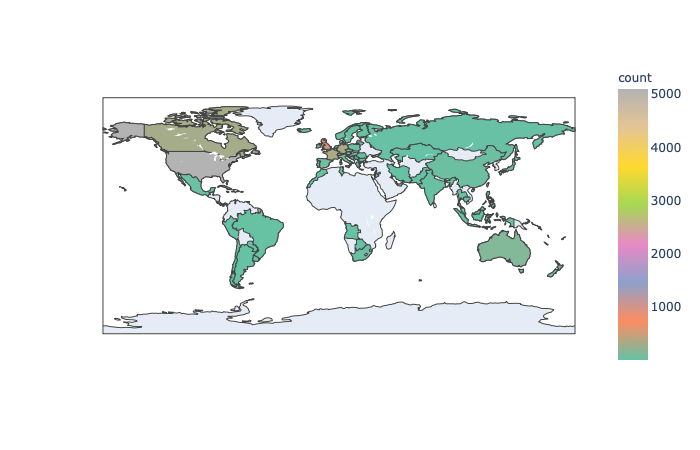

In [81]:
from IPython.display import Image
Image(filename='./Figures/geo_map.png')

The vast majority of movies are produced in USA (5082/5680 = 90%). As a result, we cannot examine how the production countries as a feature affects the ratings.

In [40]:
# dataframe with movies indexes per genre
genres_=pd.DataFrame(columns=['genre','indexes'])
genres_=genres_.set_index('genre')
exists=first_time=0
ls=[]
for index,i in final.iterrows():
    g=final.loc[index,'gernres_imdb']
    #print (genres_.index.values)
    if (g!=np.nan and g!="" and isinstance(g, str) ):
        #print (g)  
        if "[" in g:
            k=g[1:]
            k=k[:-1]
            g= k.replace(" ", "")
            g= g.replace("'", "")
            g=g.split(",")
            ls.append(g)
            for g_ in g:
                if g_ in genres_.index.values : 
                    exists=exists+1
                    genres_.loc[g_,'indexes'].append(index)
                else:
                    first_time=first_time+1
                    k=[index]
                    genres_.loc[g_] = [k]
        else:
            g= g.replace(" ", "")
            g= g.replace("'", "")
            if g in genres_.index.values : 
                exists=exists+1
                genres_.loc[g,'indexes'].append(index)
            else:
                first_time=first_time+1
                k=[index]
                genres_.loc[g] = [k]
    
    
print (first_time)
print(exists)

24
17589


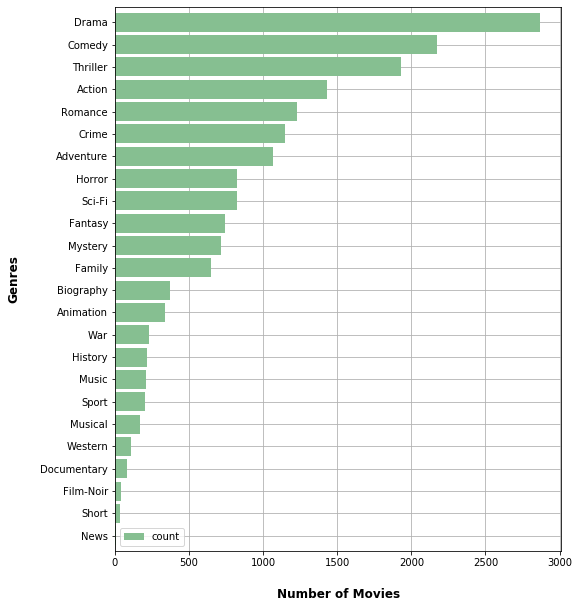

In [41]:
genres_['count']=[ len(i) for i in genres_['indexes'] ]
genres_.reset_index(drop=False, inplace=True)
genres_=genres_.sort_values(by='count')
ax = genres_.plot(kind='barh', x = 'genre', y = 'count',figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Set x-axis label
ax.set_xlabel("Number of Movies", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Genres", labelpad=20, weight='bold', size=12)

ax.grid()

We present a histogram for the number of existing movies per genre. There are 24 distinct movie genres. The most most typical genre is the drama, followed by comedy and thriller. While the 3 least common genres are Film-Noir , Short , News.


In [84]:
# dataframe with movies indexes per genre
genres_=pd.DataFrame(columns=['genre','indexes'])
genres_=genres_.set_index('genre')
exists=first_time=0
ls=[]
for index,i in final.iterrows():
    g=final.loc[index,'gernres_imdb']
    count=final.loc[index,'ratingCount_imdb']
#     print(count)
#     print (genres_.index.values)
    if (g!=np.nan and g!="" and isinstance(g, str) ):
        #print (g)  
        if "[" in g:
            k=g[1:]
            k=k[:-1]
            g= k.replace(" ", "")
            g= g.replace("'", "")
            g=g.split(",")
            ls.append(g)
            for g_ in g:
                if g_ in genres_.index.values : 
                    exists=exists+1
                    genres_.loc[g_,'indexes'].append(count)
                else:
                    first_time=first_time+1
                    k=[count]
                    genres_.loc[g_] = [k]
        else:
            g= g.replace(" ", "")
            g= g.replace("'", "")
            if g in genres_.index.values : 
                exists=exists+1
                genres_.loc[g,'indexes'].append(count)
            else:
                first_time=first_time+1
                k=[count]
                genres_.loc[g] = [k]
    
    
# print (first_time)
# print(exists)

In [48]:
genres_.head()

,indexes
genre,
Drama,"[2177591.0, 1500159.0, 2161352.0, 1739603.0, 1..."
Crime,"[1500159.0, 2161352.0, 1710354.0, 1050337.0, 1..."
Action,"[2161352.0, 1093296.0, 1909563.0, 1164801.0, 9..."
Thriller,"[2161352.0, 559972.0, 1909563.0, 413737.0, 133..."
Biography,"[1136691.0, 945970.0, 671958.0, 640044.0, 1913..."


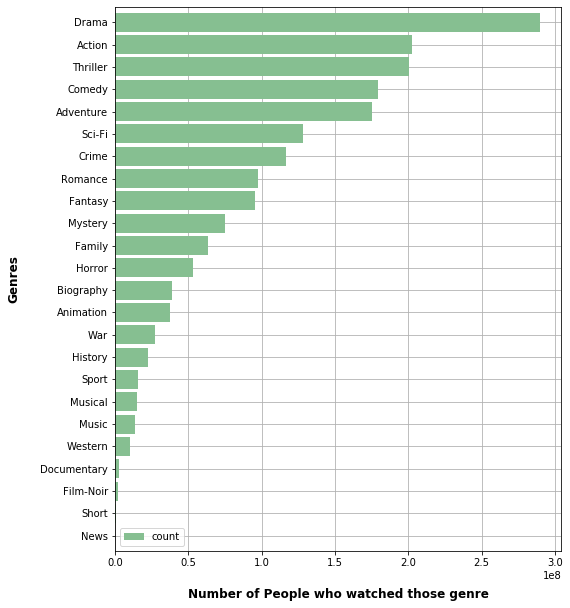

In [51]:
genres_['count']=[ sum(i) for i in genres_['indexes'] ]
genres_.reset_index(drop=False, inplace=True)
genres_=genres_.sort_values(by='count')
ax = genres_.plot(kind='barh', x = 'genre', y = 'count',figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Set x-axis label
ax.set_xlabel("Number of People who watched those genre", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Genres", labelpad=20, weight='bold', size=12)

ax.grid()

Through this barplot, we can conclude that people tend to watch more Drama movies. Afer that come Action and Thriller movies. 
While Short , Film-Noir, Docimentaries and Western movies are the least prefered by the public.

# Continue 2nd Part ----> 